<h2>Problem Statement</h2>

<b>Can we predict if a loan is likely to be paid back, and if so, what factors influnce the likelihood of being paid back?</b><br>
In other words, can we predict if a loan going to be defaulted, and what factors influence if a loan is prone to defaulting?

<h2>EDA</h2>

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split

# Regression Models
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Classification Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Evaluation metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, root_mean_squared_error, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# For combining pipelines after encoding
from sklearn.compose import make_column_selector as selector

sns.set(style="whitegrid")

In [224]:
df = pd.read_csv('playground-series-s4e10/train.csv')
df.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [225]:
# Renaming columns for easier understanding - looked at Kaggle notebooks for definitions on some variables
df = df.rename(columns={'cb_person_default_on_file': 'history_of_default',
                        'cb_person_cred_hist_length': 'cred_hist_length'})
df.head() # Confirming changes

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,history_of_default,cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [226]:
print(f"Shape of data: {df.shape}\n")
print(df.info())

Shape of data: (58645, 13)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     58645 non-null  int64  
 1   person_age             58645 non-null  int64  
 2   person_income          58645 non-null  int64  
 3   person_home_ownership  58645 non-null  object 
 4   person_emp_length      58645 non-null  float64
 5   loan_intent            58645 non-null  object 
 6   loan_grade             58645 non-null  object 
 7   loan_amnt              58645 non-null  int64  
 8   loan_int_rate          58645 non-null  float64
 9   loan_percent_income    58645 non-null  float64
 10  history_of_default     58645 non-null  object 
 11  cred_hist_length       58645 non-null  int64  
 12  loan_status            58645 non-null  int64  
dtypes: float64(3), int64(6), object(4)
memory usage: 5.8+ MB
None


In [227]:
print(f"Unique values:\n {df.nunique()}\n")
print(f"Null values:\n {df.isnull().sum()}")

Unique values:
 id                       58645
person_age                  53
person_income             2641
person_home_ownership        4
person_emp_length           36
loan_intent                  6
loan_grade                   7
loan_amnt                  545
loan_int_rate              362
loan_percent_income         61
history_of_default           2
cred_hist_length            29
loan_status                  2
dtype: int64

Null values:
 id                       0
person_age               0
person_income            0
person_home_ownership    0
person_emp_length        0
loan_intent              0
loan_grade               0
loan_amnt                0
loan_int_rate            0
loan_percent_income      0
history_of_default       0
cred_hist_length         0
loan_status              0
dtype: int64


In [228]:
df['loan_status'].value_counts(normalize=True)

loan_status
0    0.857618
1    0.142382
Name: proportion, dtype: float64

This shows us there's a class imbalance for our dependent variable. We should keep this in mind when making our models and the results of our models.

In [229]:
df.describe()

,id,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cred_hist_length,loan_status
count,58645.000000,58645.000000,5.864500e+04,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000,58645.000000
mean,29322.000000,27.550857,6.404617e+04,4.701015,9217.556518,10.677874,0.159238,5.813556,0.142382
std,16929.497605,6.033216,3.793111e+04,3.959784,5563.807384,3.034697,0.091692,4.029196,0.349445
min,0.000000,20.000000,4.200000e+03,0.000000,500.000000,5.420000,0.000000,2.000000,0.000000
25%,14661.000000,23.000000,4.200000e+04,2.000000,5000.000000,7.880000,0.090000,3.000000,0.000000
50%,29322.000000,26.000000,5.800000e+04,4.000000,8000.000000,10.750000,0.140000,4.000000,0.000000
75%,43983.000000,30.000000,7.560000e+04,7.000000,12000.000000,12.990000,0.210000,8.000000,0.000000
max,58644.000000,123.000000,1.900000e+06,123.000000,35000.000000,23.220000,0.830000,30.000000,1.000000


I noticed that person_age and person_emp_length have extremely high maximums that are unreasonable (at 123 years), so we'll check our variables through histograms to see the distribution.

person_income also has an extremely high maximum, so we'll also use a histogram to see the distribution of the data.

I'm also going to drop id from our data, as it provides no value for analysis.

In [230]:
df = df.drop(['id'], axis = 1)

In [231]:
df.to_csv('loan_data_cleaned.csv', index=1)

In [232]:
# Separating numerical and categorical variables for analysis
cat_features = df.select_dtypes(include=['object']).columns
num_features = df.select_dtypes(include=np.number).columns.tolist()

print(f"Categorical Variables: {cat_features}")
print(f"Numerical Variables: {num_features}")

Categorical Variables: Index(['person_home_ownership', 'loan_intent', 'loan_grade',
       'history_of_default'],
      dtype='object')
Numerical Variables: ['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cred_hist_length', 'loan_status']


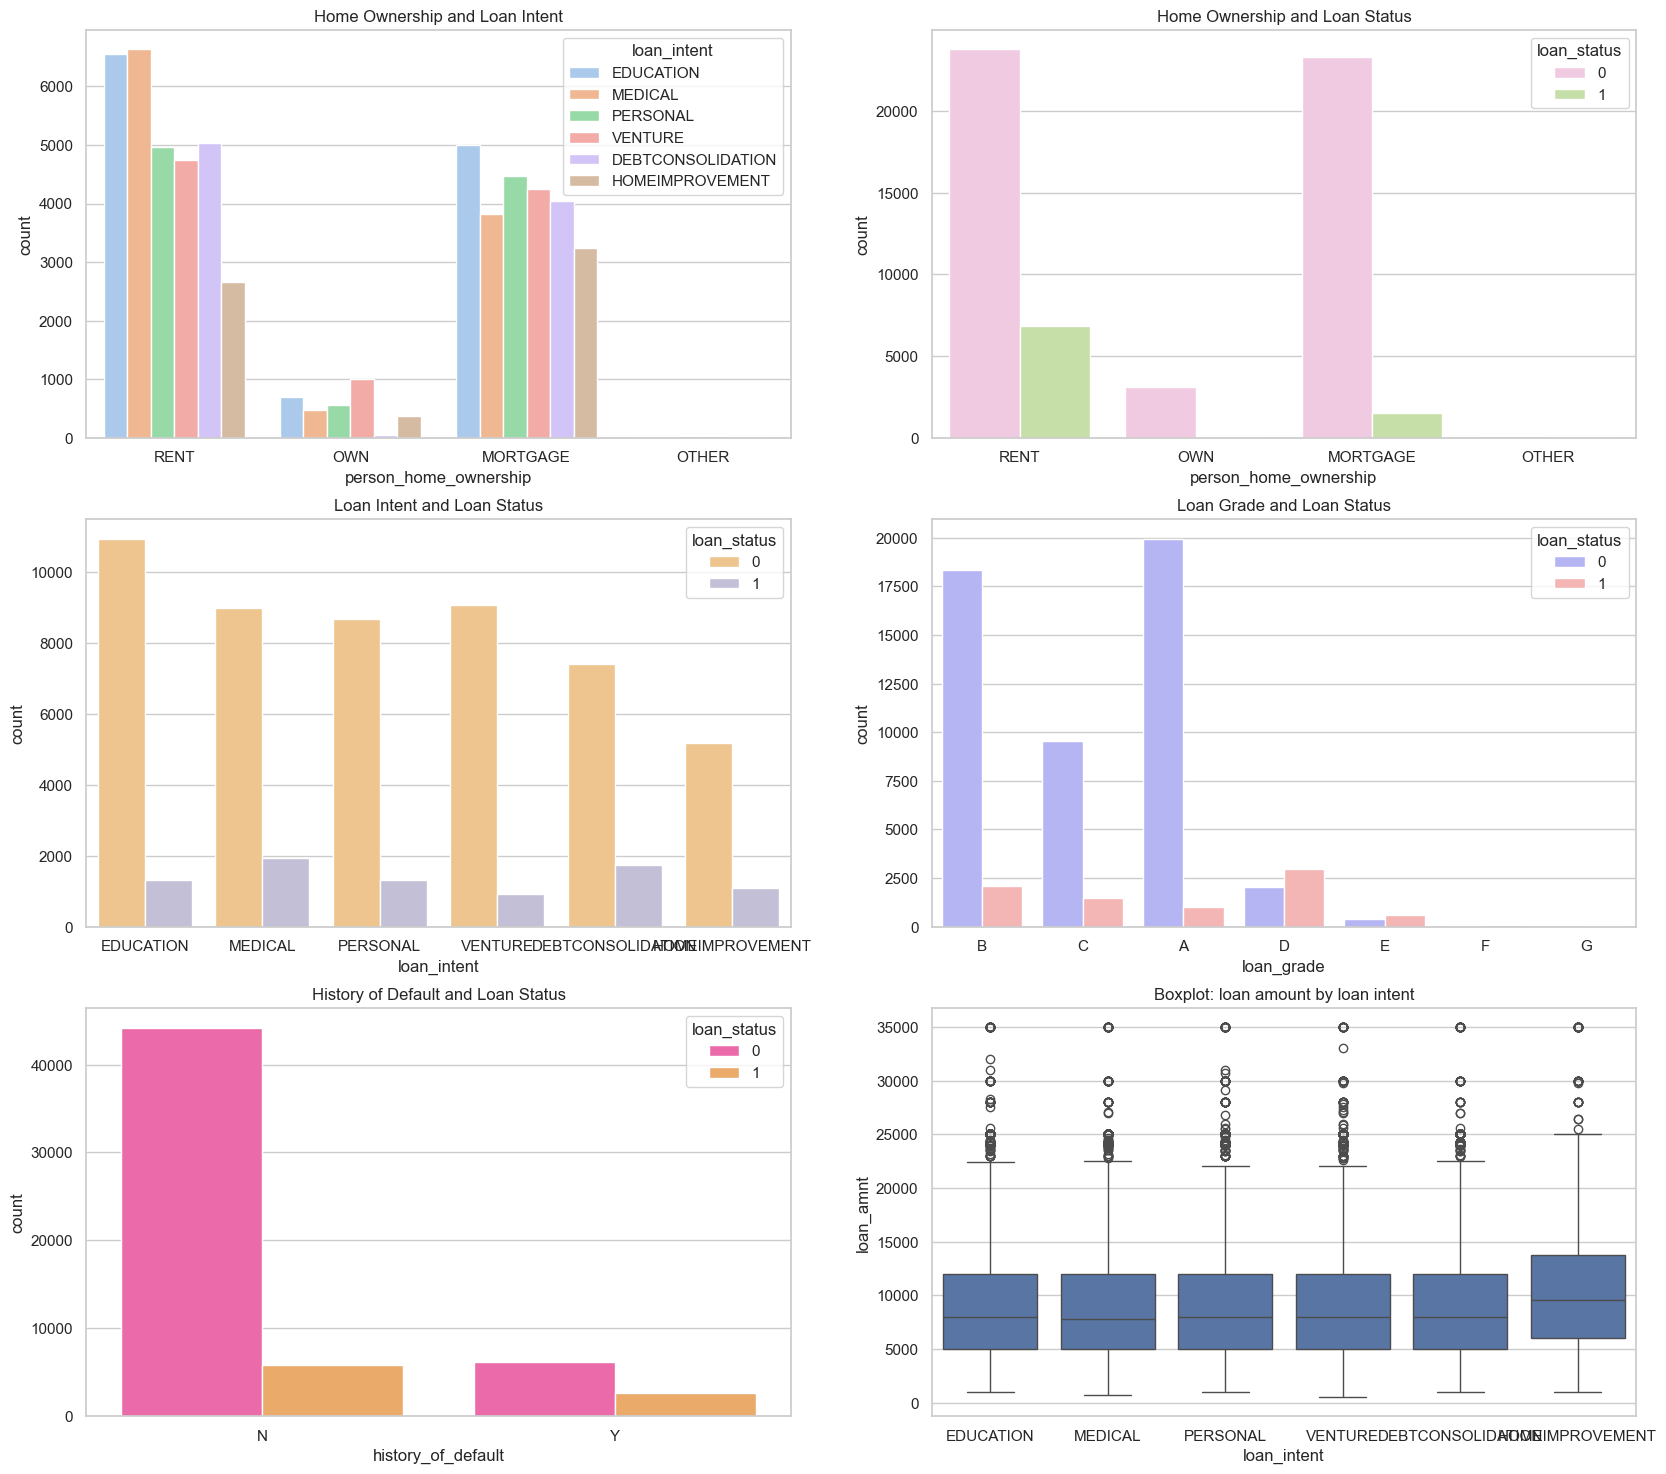

In [233]:
# Grouped bar plot for categorical vs. categorical
# Also playing around with palettes lol

fig, ax = plt.subplots(3, 2, figsize=(20, 18))

# Home Ownership and Loan Intent
sns.countplot(data=df, x='person_home_ownership', hue='loan_intent', palette='pastel', ax=ax[0,0])
ax[0,0].set_title("Home Ownership and Loan Intent")

# Home Ownership and Loan Status
sns.countplot(data=df, x='person_home_ownership', hue='loan_status', palette='PiYG', ax=ax[0,1])
ax[0,1].set_title("Home Ownership and Loan Status")

# Loan Intent and Loan Status
sns.countplot(data=df, x='loan_intent', hue='loan_status', palette='PuOr', ax=ax[1,0])
ax[1,0].set_title("Loan Intent and Loan Status")

# Loan Grade and Loan Status
sns.countplot(data=df, x='loan_grade', hue='loan_status', palette='bwr', ax=ax[1,1])
ax[1,1].set_title("Loan Grade and Loan Status")

# History of Default and Loan Status
sns.countplot(data=df, x='history_of_default', hue='loan_status', palette='spring', ax=ax[2,0])
ax[2,0].set_title("History of Default and Loan Status")

# Box plot for numerical vs. categorical
sns.boxplot(data=df, x='loan_intent', y='loan_amnt')
plt.title("Boxplot: loan amount by loan intent")
plt.show()

A lot of people who rent their homes apply for loans with a educational or medical intent. Similarly with those who mortgage their homes, but mostly apply with the intent for education and personal.

Those who rent have have a higher approval for a loan than those who mortgage, while those who own did not get approved for a loan.

Those with a medical intent appear to be approved for a loan more, however, a percentage would probably be best to determine who gets approved more (out of all intents).

Lower loan grade status (high risk) tends to get approved for a loan more, compared to high grade. This is probably because lower grades have higher interest rates.

It looks like the proportion between those with a default history and loan approval is probably higher than those without a default history and loan approval. This proportion is probably higher because those with previous default history are offered higher interest rates.

The loan amount mean and outliers across all loan intents seems to be fairly similar. 

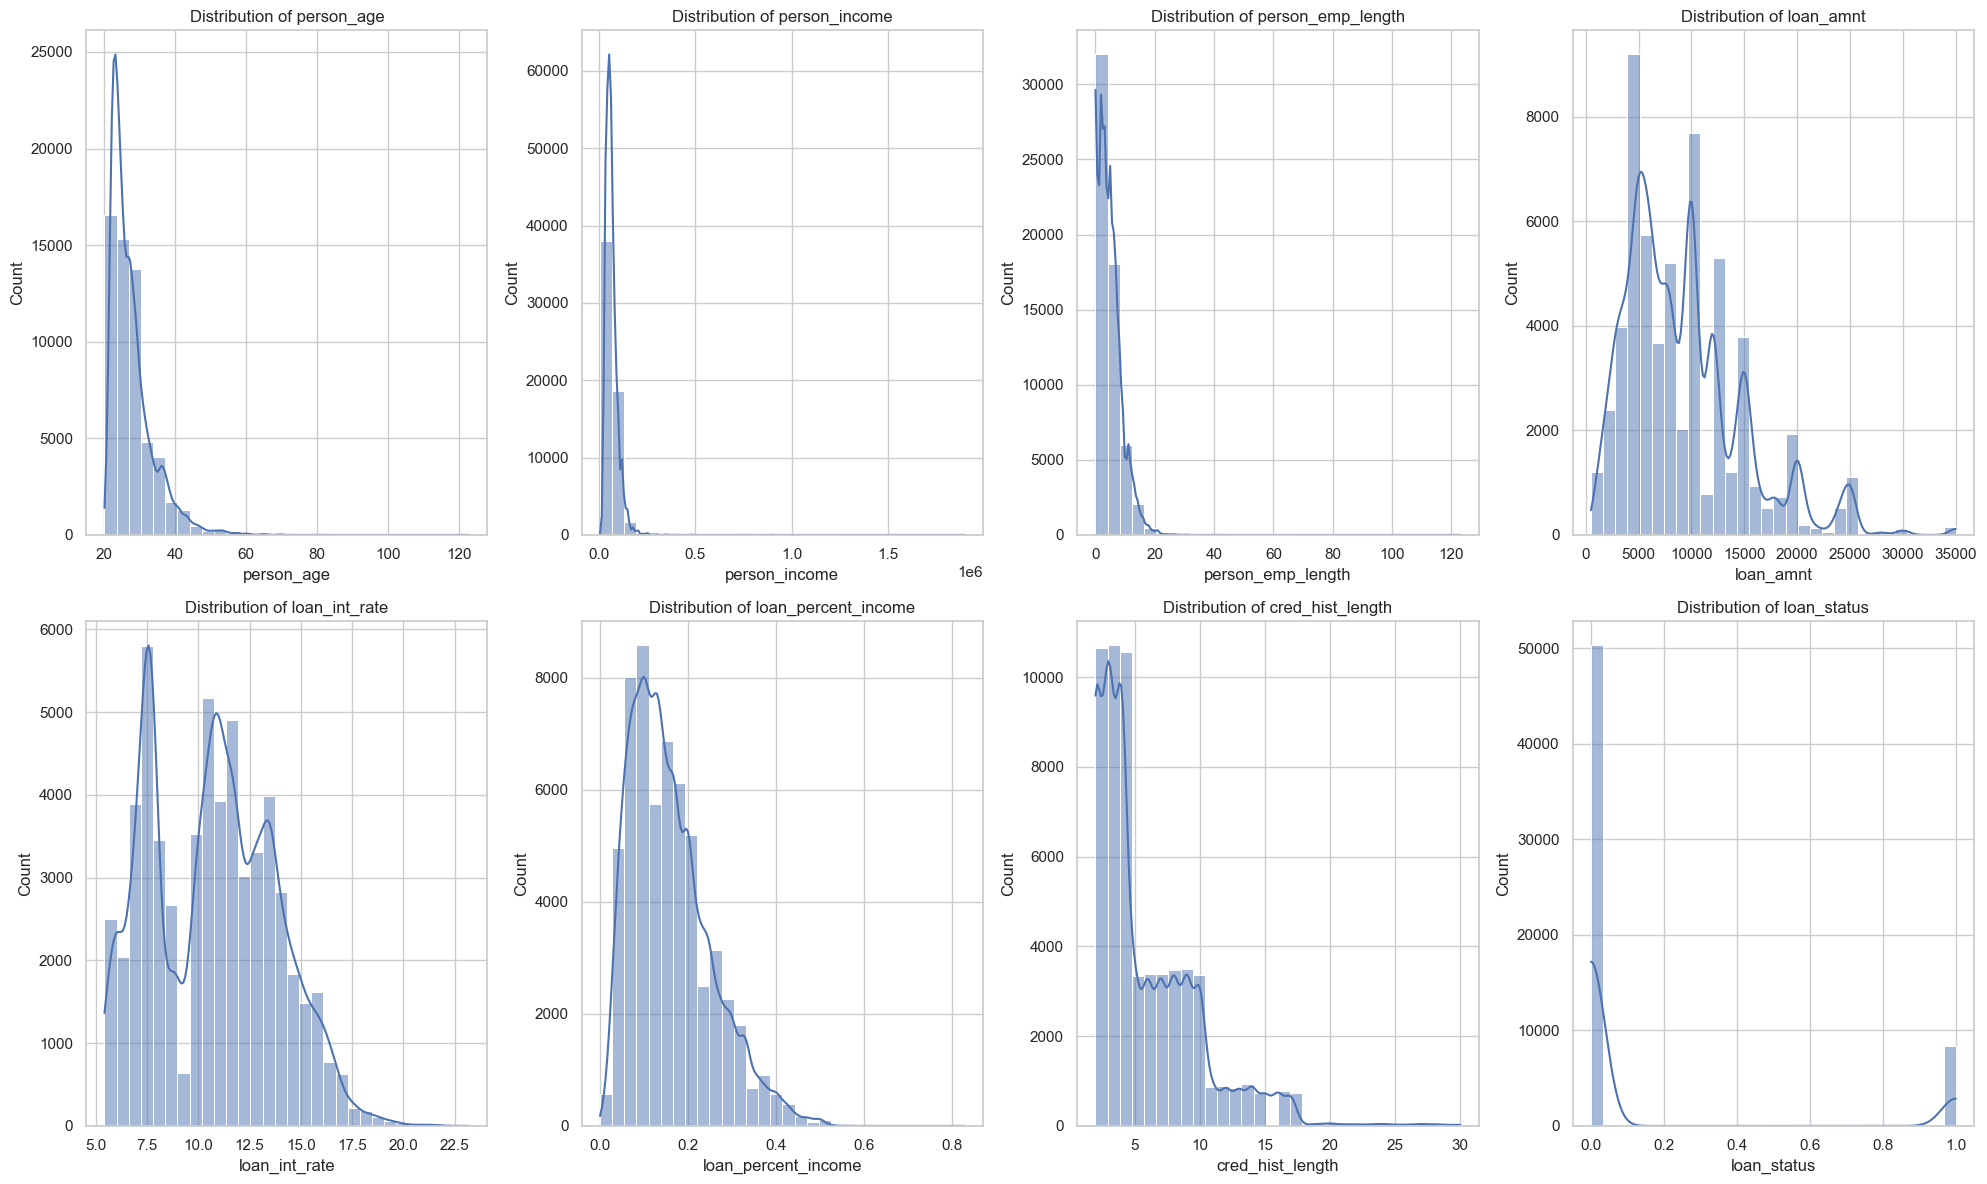

In [234]:
# Create a 2x3 grid for visualization
fig, ax = plt.subplots(2, 4, figsize=(20,12))

# Iterate over features and plot
for i, feature in enumerate(num_features):
    row, col = divmod(i, 4)
    sns.histplot(df[feature], kde=True, bins=30, ax=ax[row, col])
    ax[row, col].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

We can see that almost all of our variables are not normally distributed and mostly skewed right, so we'll use a log function to make these normal.

We won't apply a log function to loan_status, as this is our dependent variable.

In [235]:
df['log_age'] = np.log(df['person_age'])
df['log_income'] = np.log(df['person_income'])
df['log_emp'] = np.log(df['person_emp_length'])
df['log_loan_amnt'] = np.log(df['loan_amnt'])
df['log_loan_int_rate'] = np.log(df['loan_int_rate'])
df['log_loan_percent_income'] = np.log(df['loan_percent_income'])
df['log_cred_hist_length'] = np.log(df['cred_hist_length'])

log_features = {
    'log_age': df['log_age'],
    'log_income': df['log_income'],
    'log_emp': df['log_emp'],
    'log_loan_amnt': df['log_loan_amnt'],
    'log_loan_int_rate': df['log_loan_int_rate'],
    'log_loan_percent_income': df['log_loan_percent_income'],
    'log_cred_hist_length': df['log_cred_hist_length']
}

# Replacing log of 0 and negative numbers, dropping NaN values
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


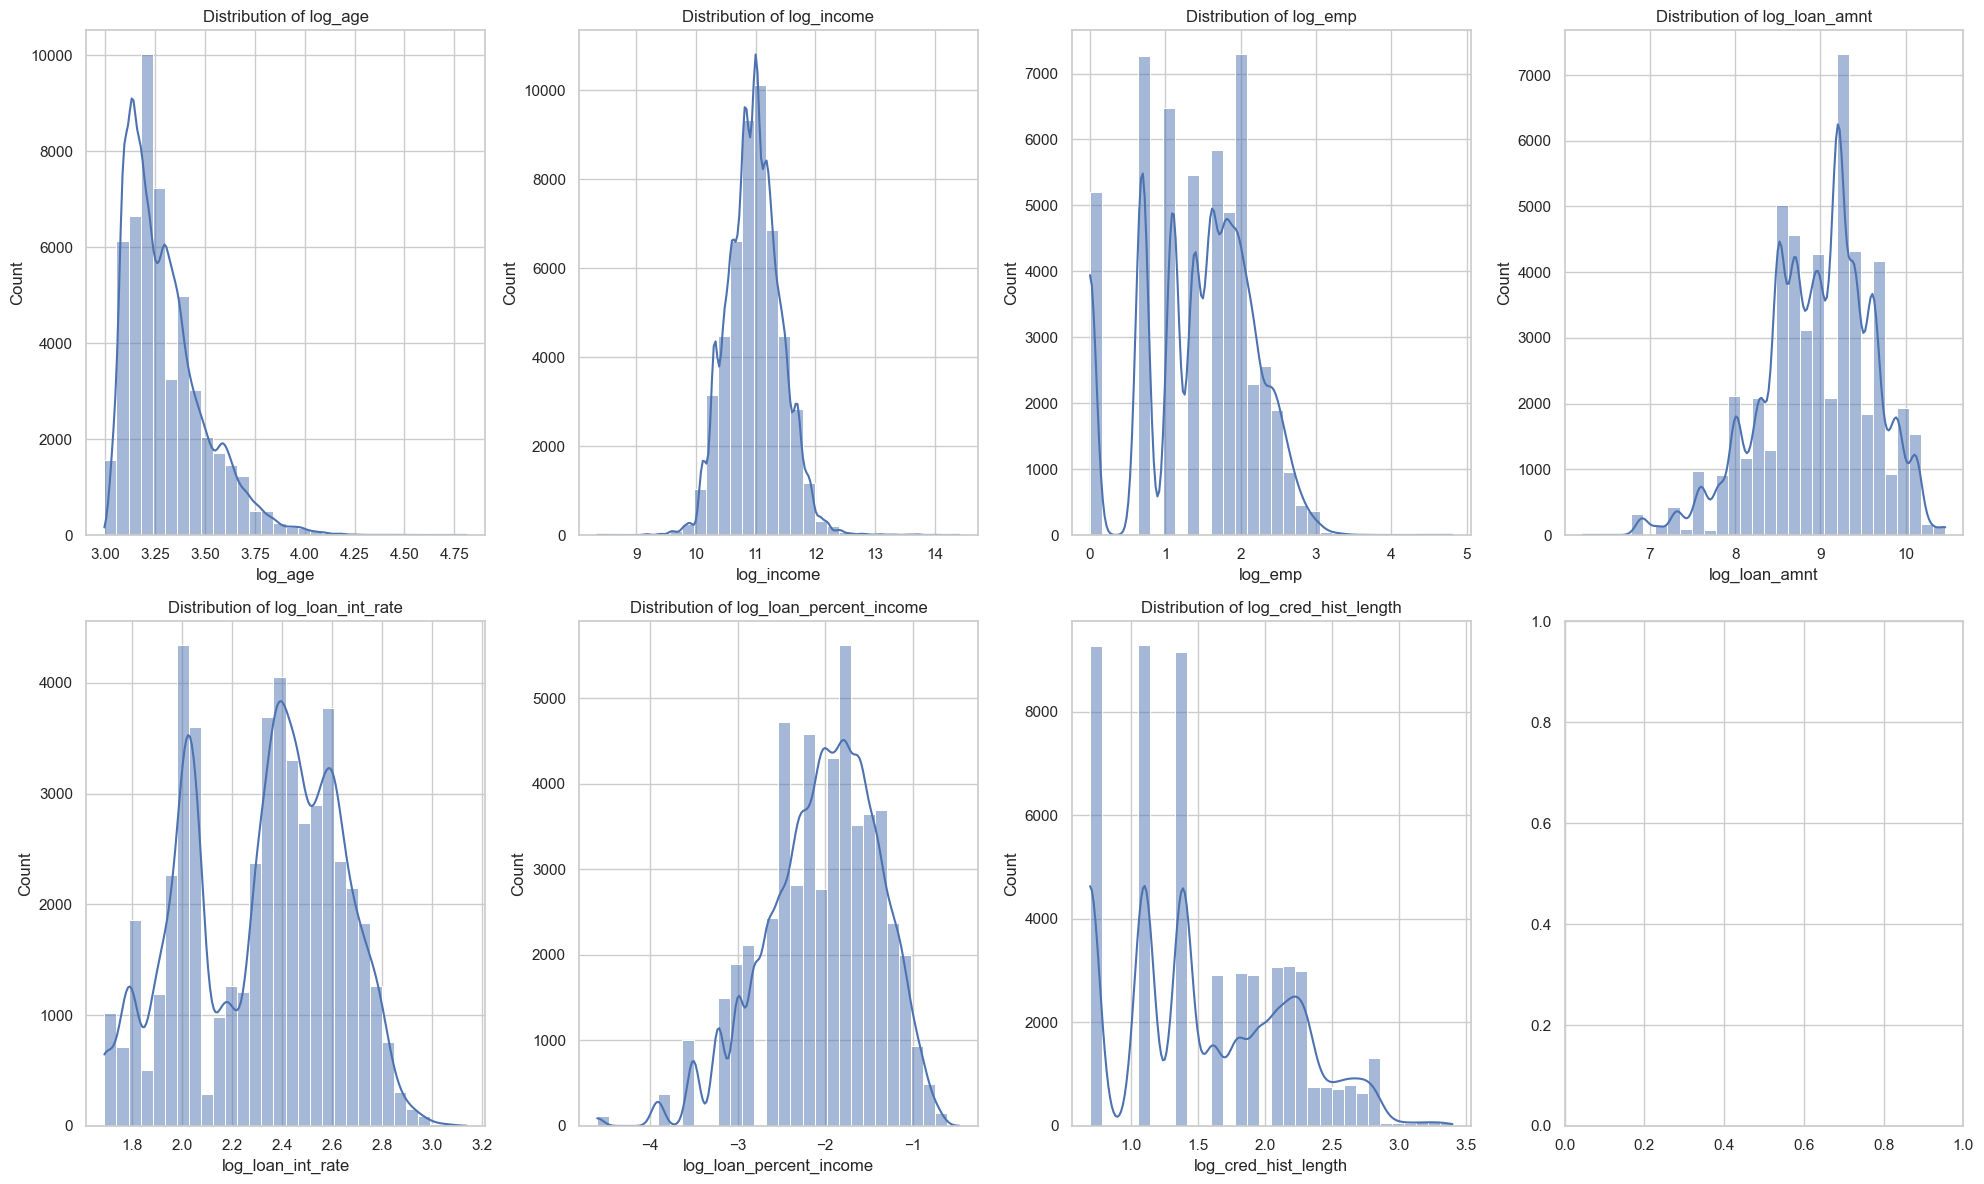

In [236]:
# Create a 2x3 grid for visualization
fig, ax = plt.subplots(2, 4, figsize=(20,12))

# Iterate over features and plot
for i, feature in enumerate(log_features):
    row, col = divmod(i, 4)
    sns.histplot(df[feature], kde=True, bins=30, ax=ax[row, col])
    ax[row, col].set_title(f'Distribution of {feature}')

plt.tight_layout()
plt.show()

log generally helps with the distribution of our data, but some variables need to be further refined such as log_age, log_emp, log_loan_amnt, and log_cred_hist_length.

We'll standardize the features using z-scores to make this normally distributed.

In [237]:
# Using Z-Scores to remove outliers as this can standardized all values
# z_scores = ['log_age', 'log_loan_amnt', 'log_loan_int_rate', 'log_loan_percent_income']

# scaler = StandardScaler()
# df[z_scores] = scaler.fit_transform(df[z_scores])

# Using Z-scores to remove extreme outliers
from scipy import stats
z_scores = np.abs(stats.zscore(df[num_features]))
df = df[(z_scores < 3).all(axis=1)]

# Using a scale to make variables compatible with logistic regression and kNN
scaler = StandardScaler()
df[num_features] = scaler.fit_transform(df[num_features])

df.shape

(48526, 19)

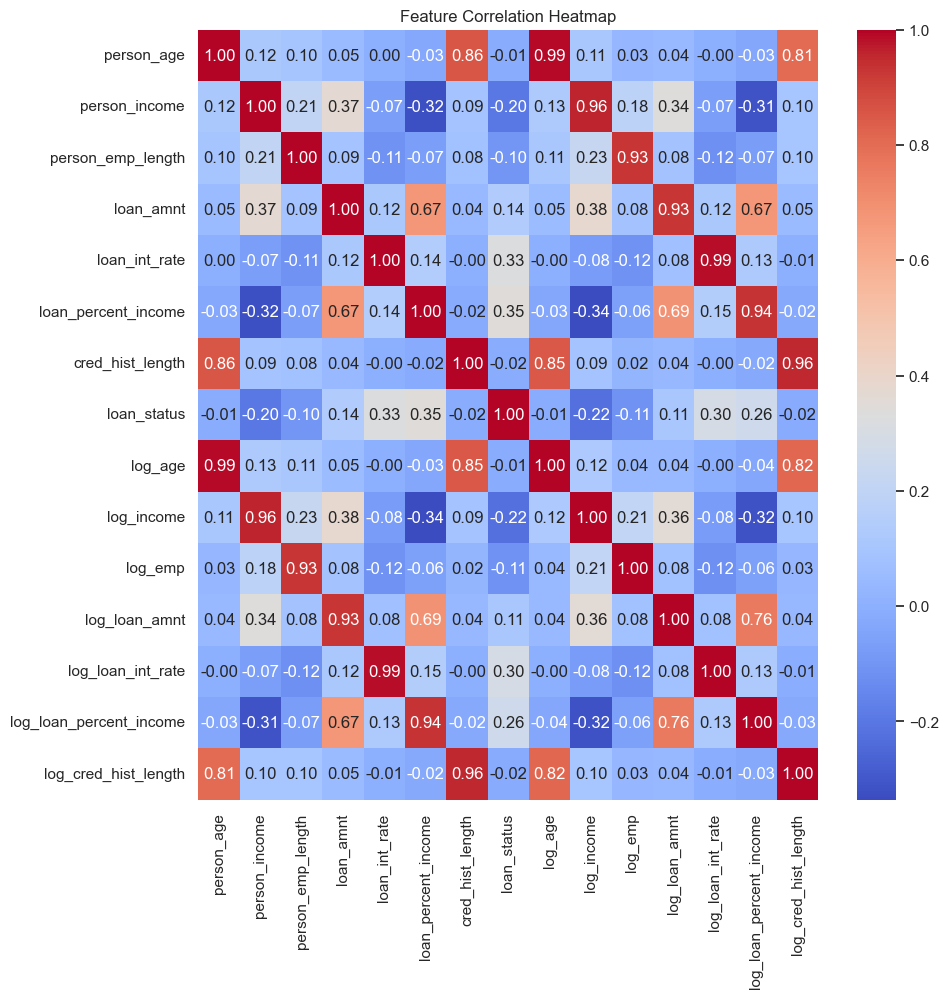

In [238]:
# Create a correlation heatmap
plt.figure(figsize=(10,10))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Dropping highly-related features will help avoid multicollinearity, alongside our variables that are not in log form.

In [239]:
df = df.drop(['person_age', 'person_income', 'person_emp_length', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cred_hist_length'], axis=1)

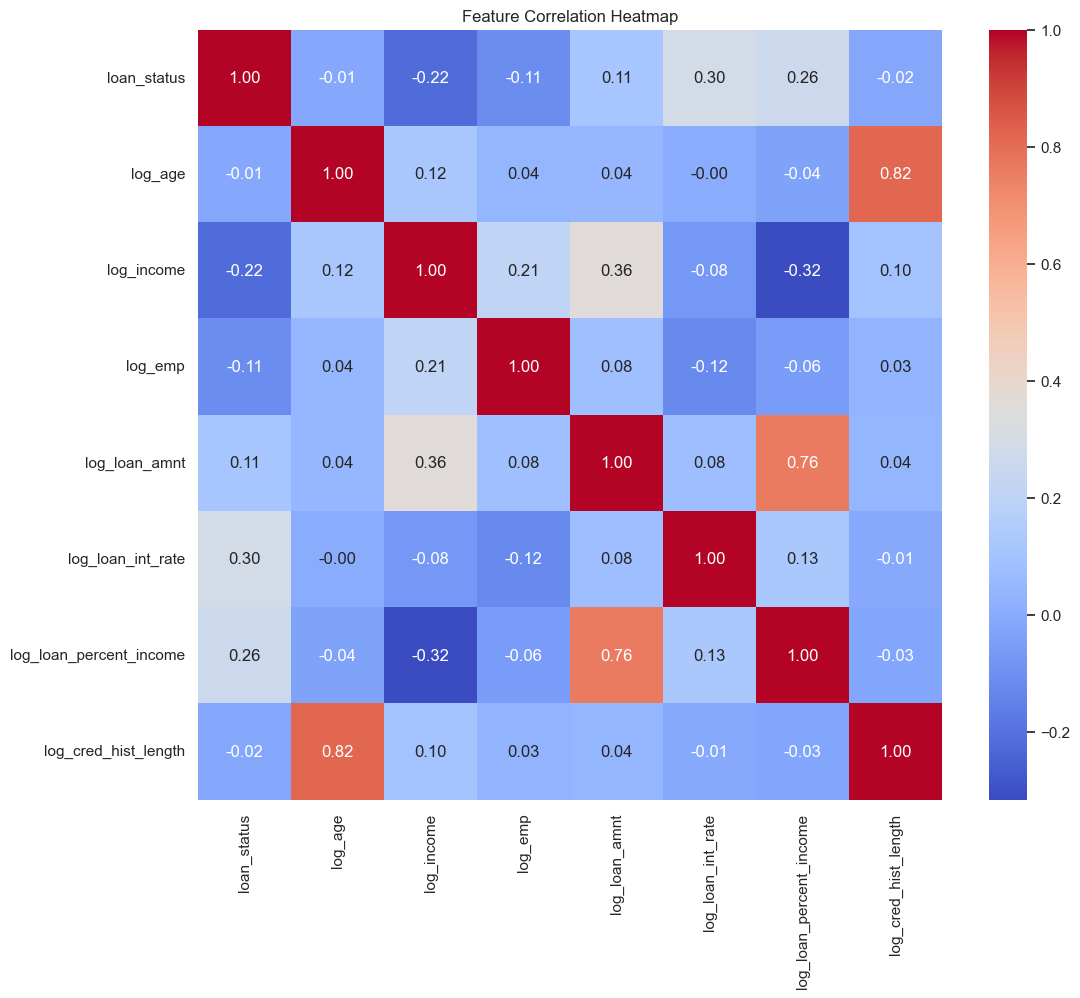

In [240]:
# Updated correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

We can drop log_age since its correlation with log_cred_hist_length is intuitive. We can assume that the older someone is, the longer credit history they have. We can also drop log_cred_hist_length later, as it does not seem to affect loan_status as much as we assume.

We can look into the correlation between log_loan_percent_income and log_loan_amnt to see if these variables are both important to the model.

In [241]:
df = df.drop(['log_age'], axis=1)

In [242]:
"""
# Converting categorical variables into numerical
# from sklearn.preprocessing import LabelEncoder
#le = LabelEncoder()

df1 = df
loan_grade_label = le.fit_transform(df['loan_grade']) # I think only loan_grade is the best for label encoder as it is ordinal
# This made loan grade start at 0, but it would be easier to understand for loan_grade if A is 1, B is 2, etc.
df1['loan_grade'] = loan_grade_label + 1

df1['person_home_ownership'] = df['person_home_ownership'].map(
    {"RENT": 1, "OWN": 2, "MORTGAGE": 3, "OTHER": 4})

df1['loan_intent'] = df['loan_intent'].map(
    {"EDUCATION": 1, "MEDICAL": 2, "PERSONAL": 3, "VENTURE": 4, "DEBTCONSOLIDATION": 5, "HOMEIMPROVEMENT": 6})

df1['history_of_default'] = df['history_of_default'].map(
    {"N": 0, "Y": 1})
"""

'\n# Converting categorical variables into numerical\n# from sklearn.preprocessing import LabelEncoder\n#le = LabelEncoder()\n\ndf1 = df\nloan_grade_label = le.fit_transform(df[\'loan_grade\']) # I think only loan_grade is the best for label encoder as it is ordinal\n# This made loan grade start at 0, but it would be easier to understand for loan_grade if A is 1, B is 2, etc.\ndf1[\'loan_grade\'] = loan_grade_label + 1\n\ndf1[\'person_home_ownership\'] = df[\'person_home_ownership\'].map(\n    {"RENT": 1, "OWN": 2, "MORTGAGE": 3, "OTHER": 4})\n\ndf1[\'loan_intent\'] = df[\'loan_intent\'].map(\n    {"EDUCATION": 1, "MEDICAL": 2, "PERSONAL": 3, "VENTURE": 4, "DEBTCONSOLIDATION": 5, "HOMEIMPROVEMENT": 6})\n\ndf1[\'history_of_default\'] = df[\'history_of_default\'].map(\n    {"N": 0, "Y": 1})\n'

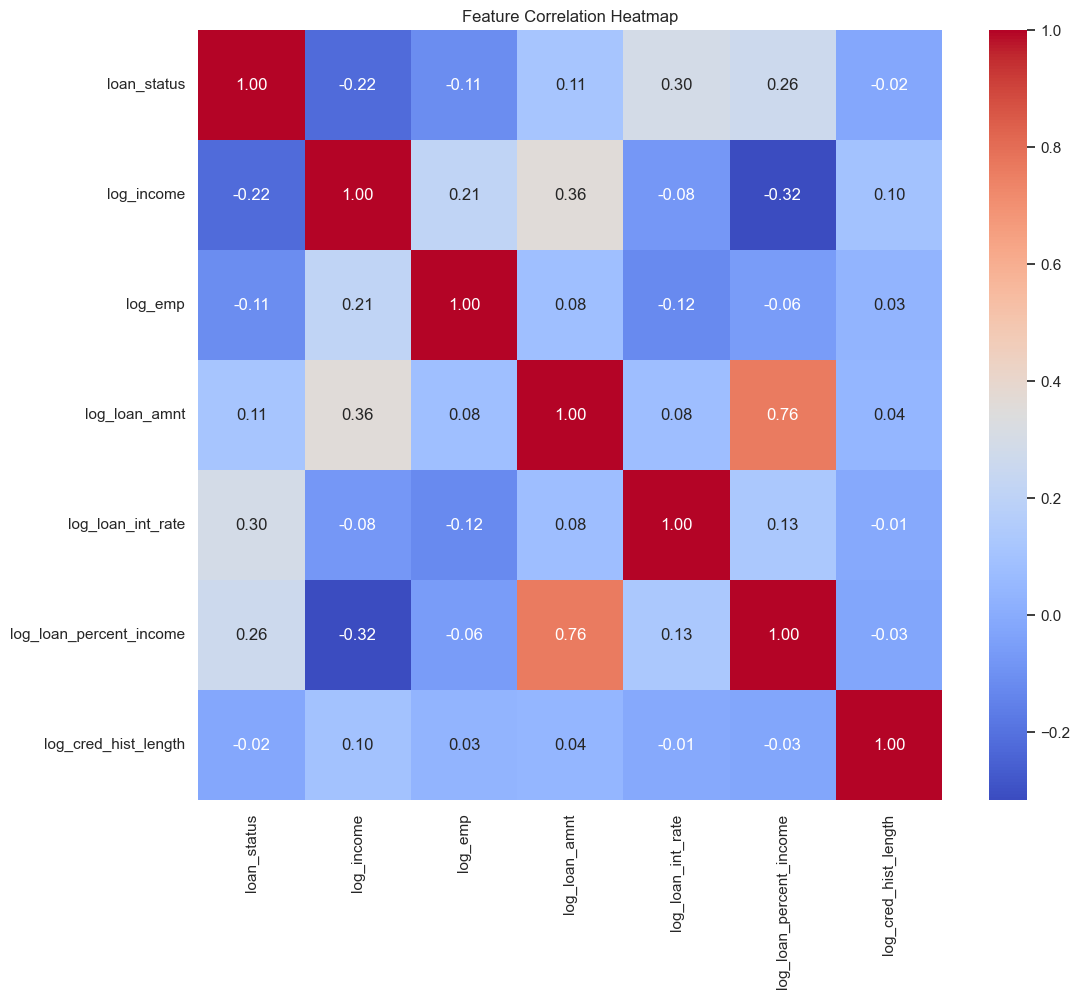

In [243]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.select_dtypes(include=['number']).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

Our most important variables for loan_status are log_loan_int_rate (at 0.30) and log_loan_percent_income (at 0.26) since they are the highest variables for predicting loan_status.

The higher the correlation, the likely loan_status is going to <i>be 1, and will default</i>. This could be because a high interest rate for a loan is more likely to be a <i>high-risk</i> loan to default.

log_loan_amnt has a high correlation to log_loan_percent_income, so it will be dropped to avoid multicollinearity and it has a lower correlation to loan_status than log_loan_percent_income.

In [244]:
df = df.drop(['log_cred_hist_length', 'log_loan_amnt'], axis=1)

In [245]:
target_cols = ['loan_status']
features = [col for col in df.columns if col not in target_cols]

cat_features = df.select_dtypes(include=['object']).columns
num_features = [col for col in features if df[col].dtype != "object"]

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features), # Numeric features being processed; scales num features while reducing effect of outliers using median and IQR
        ("cat", OneHotEncoder(drop='first'), cat_features)
    ],
    sparse_threshold=0
)

X_processed = preprocessor.fit_transform(df[features])

cat_encoded = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_features)
all_features = list(num_features) + list(cat_encoded)

df_transformed = pd.DataFrame(X_processed, columns=all_features)
print(df_transformed.head()) # All numerical features scaled to a consistent range

X = df.drop('loan_status', axis=1)
y = df['loan_status'].astype(int)
y = y.replace(2,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

   log_income   log_emp  log_loan_int_rate  log_loan_percent_income  \
0   -0.064704  0.511397           0.916133                -1.022164   
1   -1.634743  0.911152          -0.449451                 0.752011   
2    0.462148  1.688777           0.297540                 0.410763   
3    0.098191 -1.015201          -1.296945                -0.446161   
4   -0.581039 -1.015201          -0.434348                 0.673218   

   person_home_ownership_OTHER  person_home_ownership_OWN  \
0                          0.0                        1.0   
1                          0.0                        1.0   
2                          0.0                        0.0   
3                          0.0                        0.0   
4                          0.0                        0.0   

   person_home_ownership_RENT  loan_intent_EDUCATION  \
0                         0.0                    0.0   
1                         0.0                    0.0   
2                         1.0         

Logistic Regression Accuracy: 0.811787333424921


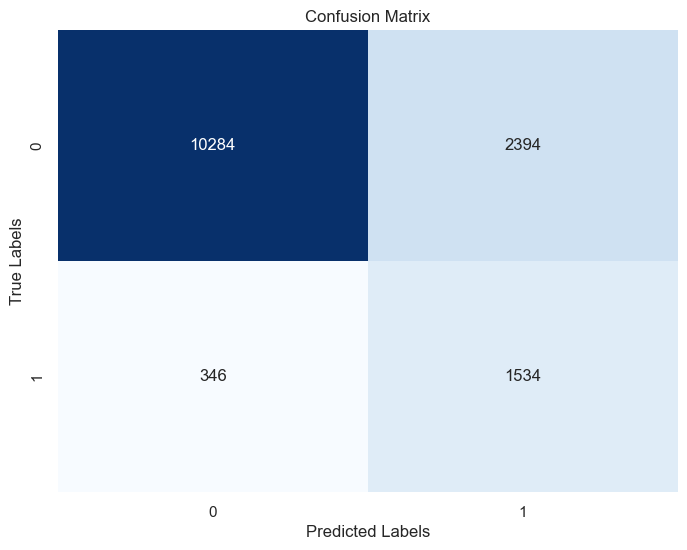

Precision: 0.3905295315682281
Recall: 0.8159574468085107
F1-Score: 0.528236914600551
ROC-AUC: 0.8135632004511082


In [246]:
# Logistic Regression for Classification
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)

log_reg.fit(X_train_processed, y_train)
y_pred_log = log_reg.predict(X_test_processed)

acc_log = accuracy_score(y_test, y_pred_log)
print("Logistic Regression Accuracy:", acc_log)

cm1 =  confusion_matrix(y_test, y_pred_log)

plt.figure(figsize=(8, 6))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

precision = precision_score(y_test, y_pred_log)
recall = recall_score(y_test, y_pred_log)
f1 = f1_score(y_test, y_pred_log)
roc_auc = roc_auc_score(y_test, y_pred_log)

print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("ROC-AUC:", roc_auc)

In [247]:
log_odds = log_reg.coef_  # This returns a 2D array (for binary classification, shape is (1, n_features))
log_odds_series = pd.Series(log_odds[0], index=all_features)
print("Logistic Regression Log Odds:")
print(log_odds_series.sort_values(ascending=False))

# The sign and magnitude of each log-odds coefficient indicate how a one-unit
# change in the feature affects the log odds of being in the positive class

Logistic Regression Log Odds:
loan_grade_D                   2.352937
loan_grade_E                   2.197872
loan_grade_F                   1.294168
person_home_ownership_OTHER    0.961824
person_home_ownership_RENT     0.823497
log_loan_percent_income        0.785980
log_loan_int_rate              0.519574
loan_intent_HOMEIMPROVEMENT    0.367706
loan_grade_G                   0.290097
history_of_default_Y           0.020832
loan_grade_C                  -0.031196
log_emp                       -0.051128
loan_grade_B                  -0.051815
loan_intent_MEDICAL           -0.124250
loan_intent_PERSONAL          -0.372710
log_income                    -0.554781
loan_intent_EDUCATION         -0.588181
loan_intent_VENTURE           -1.034478
person_home_ownership_OWN     -2.674764
dtype: float64


<h3>Decision Tree</h3>

In [248]:
# Decision Tree Classifier
dt_clf = DecisionTreeClassifier(random_state=50,max_depth=5)
dt_clf.fit(X_train_processed, y_train)
y_pred_dt_clf = dt_clf.predict(X_test_processed)
acc_dt_clf = accuracy_score(y_test, y_pred_dt_clf)
print("Decision Tree Classifier Accuracy:", acc_dt_clf)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt_clf))

pre_dt = precision_score(y_test, y_pred_dt_clf)
rec_dt = recall_score(y_test, y_pred_dt_clf)
f1_dt = f1_score(y_test, y_pred_dt_clf)
roc_auc_dt = roc_auc_score(y_test, y_pred_dt_clf)

print("Precision:", pre_dt)
print("Recall:", rec_dt)
print("F1-Score:", f1_dt)
print("ROC-AUC:", roc_auc_dt)

Decision Tree Classifier Accuracy: 0.9359802170627833
Confusion Matrix:
 [[12548   130]
 [  802  1078]]
Precision: 0.8923841059602649
Recall: 0.573404255319149
F1-Score: 0.6981865284974094
ROC-AUC: 0.7815751360205146


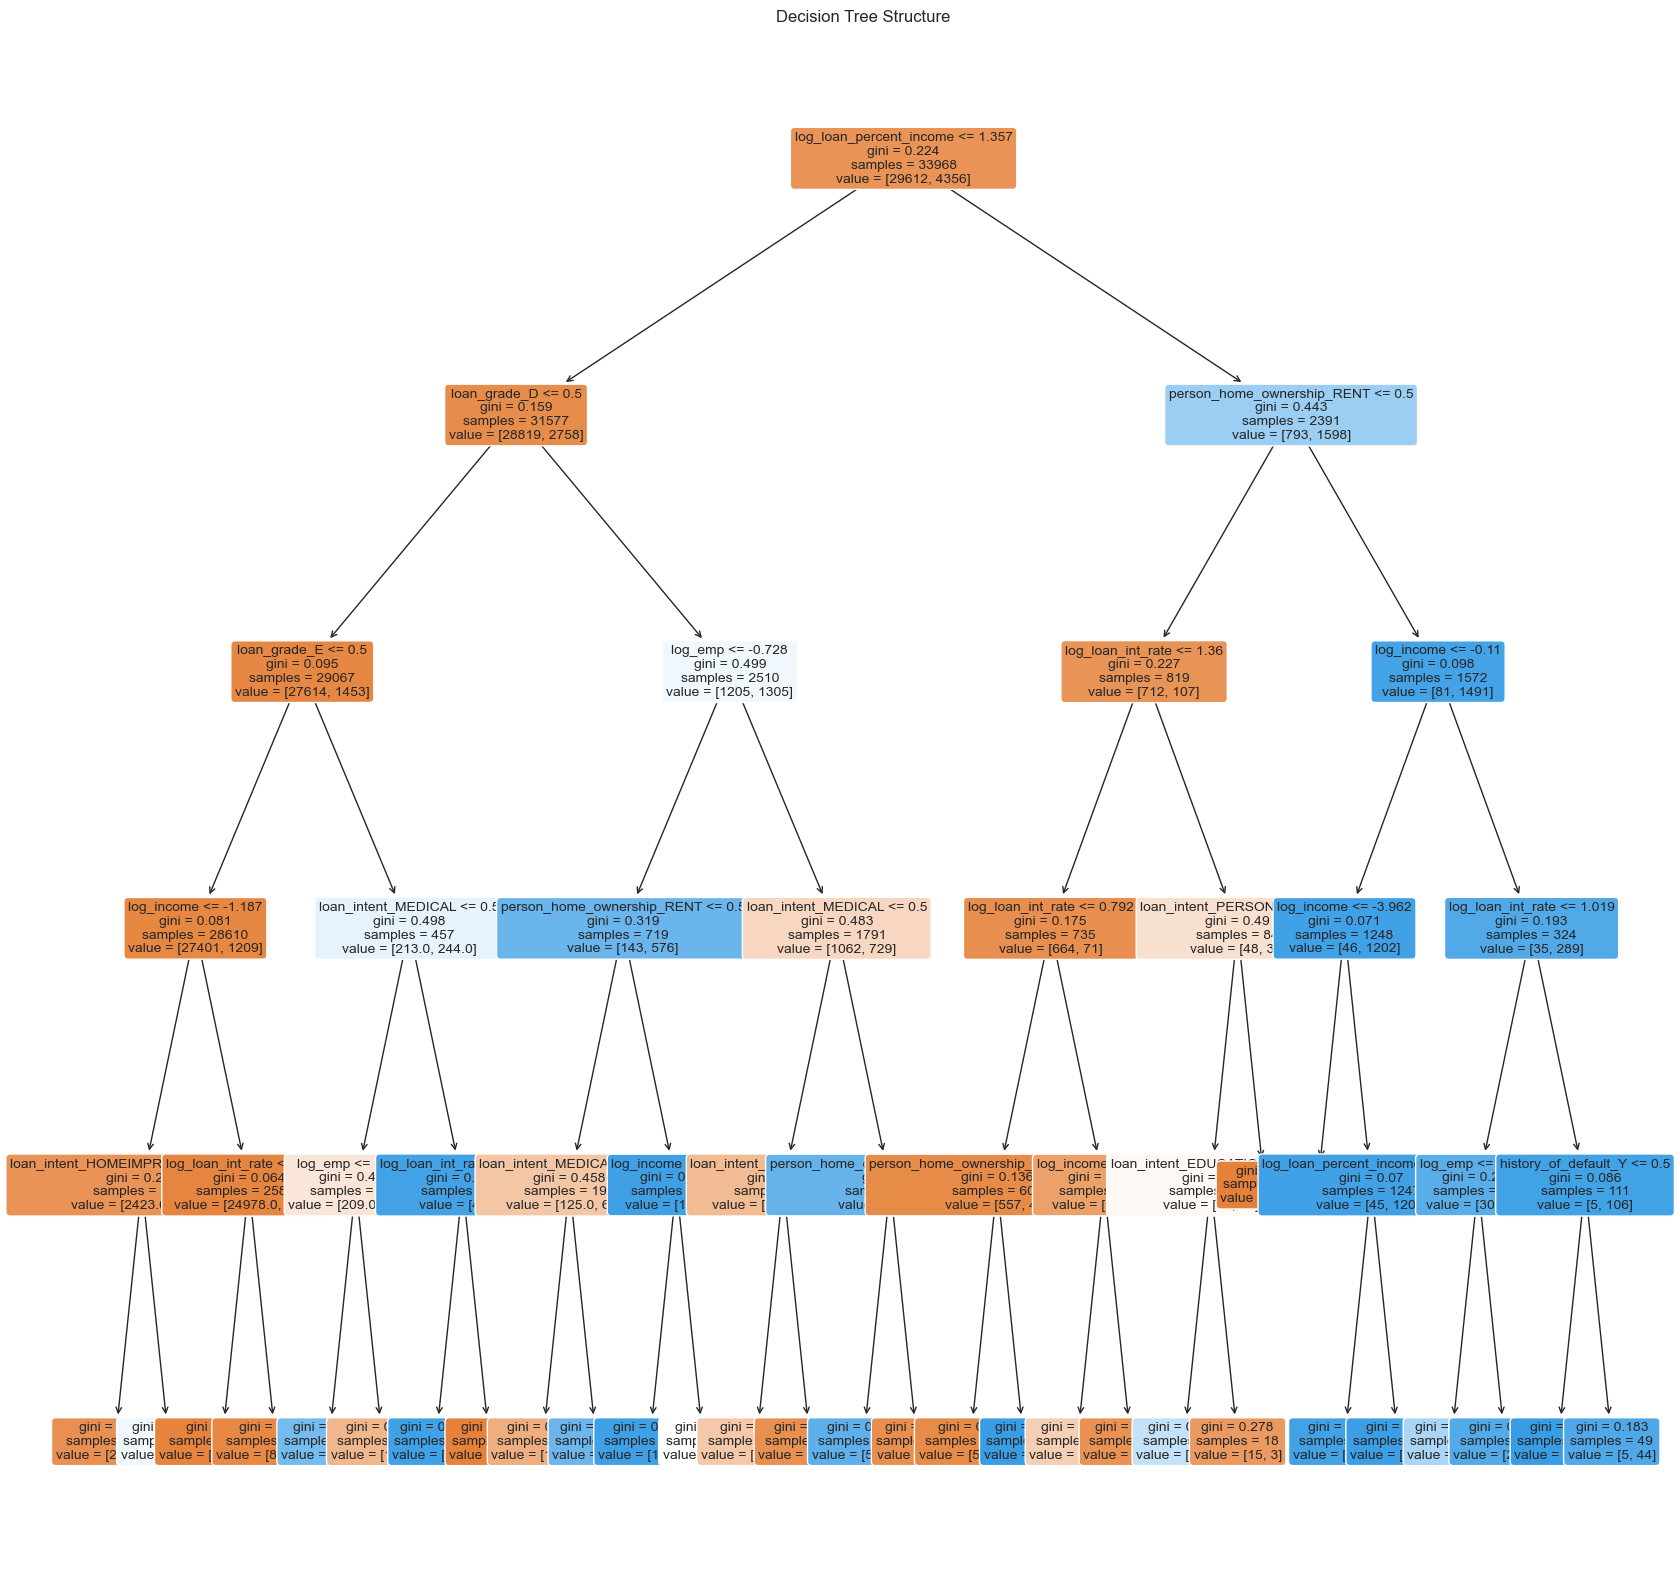

In [249]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 20))
plot_tree(dt_clf, feature_names=all_features, filled=True, rounded=True, fontsize=10)
plt.title("Decision Tree Structure")
plt.show()

<h3>Random Forest Classifier</h3>

In [250]:
# Might have to do this with person_income instead of log_person_income
# Random Forest Classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train_processed, y_train)
y_pred_rf_clf = rf_clf.predict(X_test_processed)
acc_rf_clf = accuracy_score(y_test, y_pred_rf_clf)
print("Random Forest Classifier Accuracy:", acc_rf_clf)
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf_clf))

pre_rf = precision_score(y_test, y_pred_rf_clf)
rec_rf = recall_score(y_test, y_pred_rf_clf)
f1_rf = f1_score(y_test, y_pred_rf_clf)
roc_auc_rf = roc_auc_score(y_test, y_pred_rf_clf)

print("Precision:", pre_rf)
print("Recall:", rec_rf)
print("F1-Score:", f1_rf)
print("ROC-AUC:", roc_auc_rf)

Random Forest Classifier Accuracy: 0.9496496771534552
Confusion Matrix:
 [[12552   126]
 [  607  1273]]
Precision: 0.9099356683345247
Recall: 0.6771276595744681
F1-Score: 0.7764562366575175
ROC-AUC: 0.8335945917370683


<h3>KNeighbors Classifier</h3>

In [251]:
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_processed, y_train)
knn_predict = knn.predict(X_test_processed)

knn.score(X_test_processed, y_test)

acc_knn = accuracy_score(y_test, knn_predict)

pre_knn = precision_score(y_test, knn_predict)
rec_knn = recall_score(y_test, knn_predict)
f1_knn = f1_score(y_test, knn_predict)
roc_auc_knn = roc_auc_score(y_test, knn_predict)

print("KNN Accuracy:", acc_knn)
print("Confusion Matrix:\n", confusion_matrix(y_test, knn_predict))

print("Precision:", pre_knn)
print("Recall:", rec_knn)
print("F1-Score:", f1_knn)
print("ROC-AUC:", roc_auc_knn)

# kNN values increase when removing log_age and log_cred_hist_length

KNN Accuracy: 0.9304162659706003
Confusion Matrix:
 [[12441   237]
 [  776  1104]]
Precision: 0.8232662192393736
Recall: 0.5872340425531914
F1-Score: 0.6855013970816517
ROC-AUC: 0.7842701211346175


In [252]:
df.to_csv('loan_data_log.csv', index=False)